In [1]:
#Studente: Luca Sugamosto, matricola 0324613

In [2]:
#pip install numpy
#pip install pandas
#pip install tensorflow
#pip install scikeras

In [3]:
"L'obiettivo del progetto è addestrare e valutare uno o più modelli di classificazione"
"In questa 2° versione si utilizzano delle funzioni che restituiscono i valori ottimi degli iperparametri"

# EXTENDED MNIST: versione estesa del dataset MNIST, conentente lettere alfabetiche invece delle cifre.
#                 Viene fornito un file CSV con circa 80000 immagini relative a lettere maiuscole o minuscole.
#                 Nella classificazione non occorre distinguere tra maiuscole e minuscole, quindi le classi da
#                 riconoscere sono 26.
#                 Ogni riga del file contiene l'etichetta della classe corrispondente all'immagine (un intero tra 1 e 26),
#                 seguita da 784 interi compresi tra 0 e 255 che codificano l'intensità di grigio di ogni pixel.

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import reciprocal
from scikeras.wrappers import KerasClassifier

#La seguente istruzione permette di generare i grafici all'interno dello stesso file in uso
%matplotlib inline

#Inizializzazione delle dimensioni degli elementi nel grafico
mpl.rc('axes', labelsize = 14)                       
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

In [4]:
#Fase di inizializzazione sul Data Set:
df = pd.read_csv("emnist-letters.csv")               #Lettura del file contenente i campioni del Data Set
X = df.iloc[:, 1:]                                   #Creazione della tabella delle istanze di ingresso
Y = df.iloc[:, 0]                                    #Creazione del vettore delle etichette associate alle istanze d'ingresso

#Normalizzazione degli attributi dei vettori d'ingresso così da avere valori compresi tra [0,1]
X = X/255

#Con la seguente istruzione si prende la tabella delle istanze di ingresso e si crea un vettore di 88800 elementi,
#dove ogni elemento è una matrice di dimensione 28 x 28 che sta ad indicare una singola instanza di ingresso
X = X.to_numpy().reshape(-1, 28, 28, order = "F")
print("Dimensione della variabile X:", X.shape, "\n")

#Con la seguente istruzione si prende la colonna delle etichette selezionata in precedenza e si trasforma
#in un vettore di dimensione 88800 x 1; in aggiunta il "-1" permette di indicare le 26 classi a partire
#dall'indice 0 e non 1. Quindi Y ha valori al suo interno compresi  tra 0 e 25
Y = Y.to_numpy()-1
print("Dimensione della variabile Y:", Y.shape, "\n")

#Suddivisione delle istanze del Data Set in Training Set e Test Set (rispettivamente 80% e 20%)
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#Suddivisione delle istanze del Training Set appena creato in Training Set e Validation Set (rispettivamente 85% e 15%)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_full, Y_train_full, test_size = 0.15, random_state = 42)

print("Numero di campioni contenuti nel Training Set:", X_train.shape[0])
print("Numero di campioni contenuti nel Validation Set:", X_validation.shape[0])
print("Numero di campioni contenuti nel Test Set:", X_test.shape[0])

Dimensione della variabile X: (88800, 28, 28) 

Dimensione della variabile Y: (88800,) 

Numero di campioni contenuti nel Training Set: 60384
Numero di campioni contenuti nel Validation Set: 10656
Numero di campioni contenuti nel Test Set: 17760


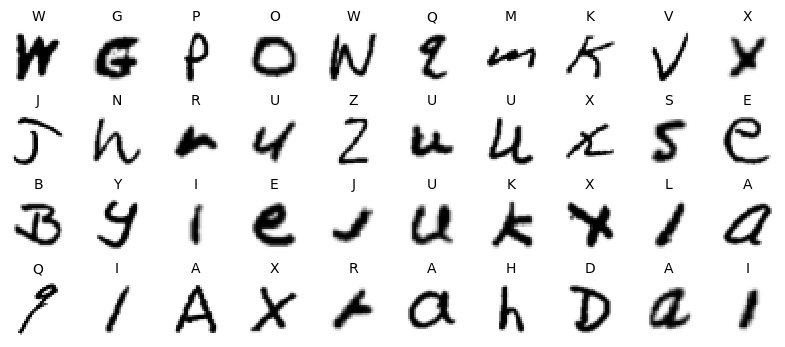

In [5]:
#Stampa a schermo di alcune istanze di ingresso (immagini di lettere scritte a mano)
#da passare successivamente in ingresso alla rete neurale
NN_input = X                                         #Si considera tutto il Data Set
NN_output = Y                                        #Si considera tutto il Data Set

#Sempre per un fatto legato alla stampa a schermo, si inizializza un vettore
#contenente tutte le 26 lettere dell'alfabeto per mostrare quale è la lettera reale
#associata all'immagine stampata
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L",
               "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
               "Y", "Z"]

n_rows = 4                                           #Numero di immagini da stampare per riga
n_cols = 10                                          #Numero di immagini da stampare per colonna
plt.figure(figsize = (n_cols * 1, n_rows * 1))       #Dimensione delle singole immagini da stampare
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(NN_input[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(class_names[NN_output[index]], fontsize = 10)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)      #Spazio in altezza e larghezza tra le varie immagini
plt.show()

In [6]:
#Utilizzo della funzione "build_model" per la creazione del modello da addestrare. 
#Essa prende in ingresso gli iperparametri della rete neurale 
#(numero di strati nascosti, numero di neuroni, valore del learning rate) e restituisce un modello
def build_model (n_hidden = 3, n_units = 100, learning_rate = 0.01):
    #Il modello utilizzato è quello SEQUENZIALE, quindi la rete neurale si compone di strati densi
    #(ciò significa che gli strati sono completamente connessi). Ogni strato possiede una propria
    #funzione di attivazione ed un certo numero di neuroni scelti casualmente
    model = keras.models.Sequential()
            
    model.add(keras.layers.Flatten(input_shape = [28, 28]))               #Strato d'ingresso con funzione Identità
    for i in range(n_hidden):
        #Creando in questo modo gli strati nascosti si ha che tutti essi
        #possiedono lo stesso numero di neuroni
        model.add(keras.layers.Dense(n_units, activation = "relu"))       #Strato nascosto i-esimo con funzione ReLU
    model.add(keras.layers.Dense(26, activation = "softmax"))             #Strato d'uscita con funzione Softmax                                                  
    
    model.summary()                                                       #Restituisce la descrizione della rete
                                                                          #neurale appena definita
    
    model.compile(loss = "sparse_categorical_crossentropy",               #Funzione di perdita
              optimizer = keras.optimizers.SGD(learning_rate),            #Algoritmo di ottimizzazione
              metrics = ["accuracy"])                                     #Funzione di valutazione
    
    return model

In [7]:
#Inizializzazione degli intervalli di valore che gli iperparametri possono assumere
#durante la fase di addestramento
param_distribs = {
    "n_hidden" : [1, 2, 3, 4],                                            #Numero di strati nascosti possibili
    "n_units" : np.arange(16, 256).tolist(),                              #Numero di neuroni possibili per ogni strato
    "learning_rate": reciprocal(1e-4, 5e-2).rvs(1000).tolist(),           #Valori di Learning Rate possibili
}   #"rvs(1000)" permette di definire 1000 campioni casuali dalla distribuzione specificata, mentre
    #"tolist()" permette di convertire l'insieme dei campioni presi in una lista 

#Inizializzazione di una classe Keras contenente la funzione utile alla creazione del modello
#e le caratteristiche più importanti come funzione di perdita e iperparametri
keras_clf = KerasClassifier(
    model = build_model,                                                  #Creazione del modello da addestrare
    loss = "sparse_categorical_crossentropy",                             #Funzione di perdita
    n_units = 32, n_hidden = 2, learning_rate = 0.001                     #Iperparametri utilizzati
)

#La seguente funzione permette di creare un oggetto per la ricerca dei parametri ottimi.
#Porre in ingresso la classe (modello), le distribuzioni (gli intervalli di valori degli iperparametri) ed alcuni parametri
#della funzione "RandomizedSearchCV"
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter = 20, cv = 2, verbose = 2)    
#Il parametro "n_iter" indica quanti modelli diversi generare e quindi addestrare
#Il parametro "cv" indica per quante volte addestrare uno specifico modello. Dato questo parametro si ha che
#Il parametro "verbose" indica il tipo di messaggio che viene stampato a schermo alla fine di ogni iterazione
#il numero di batch totali da usare viene diviso per "cv" ed ad ogni addestramento viene usato solo 
#quel numero batch calcolato. 

#Fase di addestramento dei modelli:
#La seguente funzione permette l'addestramento del modello creato con la funzione precedente
rnd_search_cv.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs = 30,
                  validation_data = (X_validation, Y_validation),
                  #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
                  #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
                  callbacks = [keras.callbacks.EarlyStopping(patience = 10)]
                 )

Fitting 2 folds for each of 20 candidates, totalling 40 fits

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 79)                62015     
                                                                 
 dense_1 (Dense)             (None, 79)                6320      
                                                                 
 dense_2 (Dense)             (None, 79)                6320      
                                                                 
 dense_3 (Dense)             (None, 26)                2080      
                                                                 
Total params: 76735 (299.75 KB)
Trainable params: 76735 (299.75 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

RandomizedSearchCV(cv=2,
                   estimator=KerasClassifier(learning_rate=0.001, loss='sparse_categorical_crossentropy', model=<function build_model at 0x000001E0D5AD07C0>, n_hidden=2, n_units=32),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0042691405218078585,
                                                          0.0007243997423898546,
                                                          0.0007254632104429761,
                                                          0.008164820527705055,
                                                          0.03394500555446461,
                                                          0.0001007544464...
                                                          0.0006613596502443279,
                                                          0.00043087840538487773,
                                                          0.019360366406394835,
                                                          0.037676868979072874,
                                                          0.04980961432433714,
                                                          0.005872527992650908,
                                                          0.012268159385678132,
                                                          0.002382033564699861,
                                                          0.002135899159038359,
                                                          0.01210301713062065, ...],
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_units': [16, 17, 18, 19, 20, 21, 22,
                                                    23, 24, 25, 26, 27, 28, 29,
                                                    30, 31, 32, 33, 34, 35, 36,
                                                    37, 38, 39, 40, 41, 42, 43,
                                                    44, 45, ...]},
                   verbose=2)

In [8]:
#A questo punto si ottiene la combinazione di iperparametri con cui si ha avuto risultati migliori
#e si ottiene anche il modello (quindi i parametri (w, b)) con cui si ha avuto risultati migliori
iperparameters = rnd_search_cv.best_params_
print("Iperparametri ottimi trovati:", iperparameters,"\n")

#Il modello ottimo dovrà essere utilizzato sul Test Set per valutare l'errore di generalizzazione
model = rnd_search_cv.best_estimator_.model_

print("Funzione di perdita - Valore di accuratezza sul Test Set:")
results = model.evaluate(X_test, Y_test)


Iperparametri ottimi trovati: {'n_units': 198, 'n_hidden': 3, 'learning_rate': 0.02198998294614173} 

Funzione di perdita - Valore di accuratezza sul Test Set:
555/555 [==============================] - 1s 2ms/step - loss: 0.4065 - accuracy: 0.8994


In [9]:
#Creazione di un nuovo modello usando gli iperparametri ottimi trovati nella fase precedente.
#I parametri (w, b) di tale modello vanno addestrati.
#Questo passaggio viene fatto per controllare se effettivamente i valori degli iperparametri
#calcolati permettono di creare un modello che restituisca una percentuale di predizione alta.

#Il modello utilizzato è quello SEQUENZIALE, quindi la rete neurale si compone di strati densi
#(ciò significa che gli strati sono completamente connessi). Ogni strato possiede una propria
#funzione di attivazione ed un certo numero di neuroni scelti dall'utente sulla base di simulazioni 
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Flatten(input_shape = [28, 28]))         #Strato d'ingresso con funzione identità

model_2.add(keras.layers.Dense(198, activation = "relu"))         #1° strato nascosto con funzione ReLU
model_2.add(keras.layers.Dense(198, activation = "relu"))         #2° strato nascosto con funzione ReLU
model_2.add(keras.layers.Dense(198, activation = "relu"))         #3° strato nascosto con funzione ReLU

model_2.add(keras.layers.Dense(26, activation = "softmax"))       #Strato d'uscita con funzione Softmax

model_2.summary()
model_2.compile(loss = "sparse_categorical_crossentropy",                                #Funzione di perdita
              optimizer = keras.optimizers.SGD(learning_rate = 0.02198998294614173),     #Algoritmo di ottimizzazione
              metrics = ["accuracy"])                                                    #Funzione di valutazione

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 784)               0         
                                                                 
 dense_156 (Dense)           (None, 198)               155430    
                                                                 
 dense_157 (Dense)           (None, 198)               39402     
                                                                 
 dense_158 (Dense)           (None, 198)               39402     
                                                                 
 dense_159 (Dense)           (None, 26)                5174      
                                                                 
Total params: 239408 (935.19 KB)
Trainable params: 239408 (935.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
#Fase di addestramento della nuova rete neurale "model_2":
"L'addestramento è la fase più importante perchè consiste nel definire i valori ottimi dei parametri (w, b)"
print("-----Fit model on Training Set-----\n")
history = model_2.fit(                                     #Tale funzione viene assegnata alla variabile "history" così
    X_train,                                               #da graficarne successivamente l'andamento nel tempo
    Y_train,
    batch_size = 32,                                       #Numero di campioni contenuti in ogni mini-batch
    epochs = 30,                                           #Numero di volte che tutti i campioni devono essere analizzati
    validation_data = (X_validation, Y_validation),        #Si passa il Validation Set per monitorare la perdita 
                                                           #di convalida e le metriche alla fine di ogni epoca
    
    #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
    #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
    callbacks = [keras.callbacks.EarlyStopping(patience = 10)]
)

-----Fit model on Training Set-----

Epoch 1/30
1887/1887 [==============================] - 7s 3ms/step - loss: 1.3450 - accuracy: 0.6147 - val_loss: 0.8341 - val_accuracy: 0.7552
Epoch 2/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.6779 - accuracy: 0.7973 - val_loss: 0.5806 - val_accuracy: 0.8255
Epoch 3/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.5093 - accuracy: 0.8438 - val_loss: 0.4844 - val_accuracy: 0.8536
Epoch 4/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.4237 - accuracy: 0.8658 - val_loss: 0.4222 - val_accuracy: 0.8702
Epoch 5/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.3695 - accuracy: 0.8826 - val_loss: 0.4164 - val_accuracy: 0.8735
Epoch 6/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.3325 - accuracy: 0.8927 - val_loss: 0.3805 - val_accuracy: 0.8820
Epoch 7/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.3012 - accuracy: 0.90

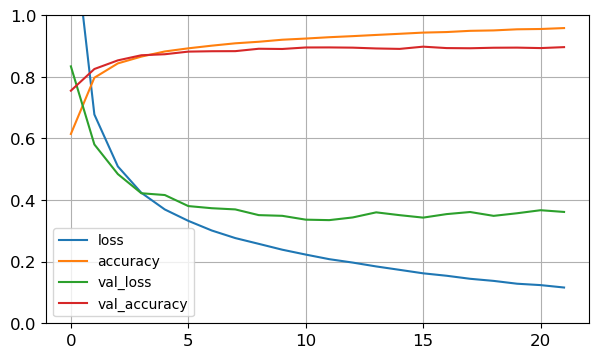

In [11]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history.history).plot(figsize = (7, 4))           #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()